# SVC Model Performance

As a test, I'm going to use the data set that gave us the best results when running logistic regression (TFIDF with unigrams, bi-grams, and tri-grams with 4k features) and run it through SVC model

SVC is non-linear. And from looking at our data in our previous notebook, it looks to be non-linear so hopefully results will be better


# Results

Unfortunately, not only did SVC take significantly longer to train and predict. The preformance of the SVC model is worse that Logistic Regression
* SVC took around 5 hours to train and predict vs LR that takes less an hour to train
* SVC performed about 15% worse using our custom metric
    * SVC not do well at all in our classification - while some of our majority class precision and recall increased. Our manority class recall especially for 2-star reviews reduces


We will not be using SVC moving forward

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util.model_util as mu
import util.report_util as ru
import logging
import json

plt.rcParams.update({'font.size': 22})
%matplotlib inline
sns.set()
logging.basicConfig(level=logging.INFO)

log = logging.getLogger(__name__)

pd.set_option('max_colwidth', 150)

CONFIG_DIR = "../config"
CONFIG_FILE_SVC = f'{CONFIG_DIR}/2019-11-01-run_classifiers-svc.csv'
REPORT_DIR = "../reports"
REPORT_FILE_SVC = f'{REPORT_DIR}/2019-11-01-run_classifiers-svc-report.csv'
REPORT_FILE_LR = f'{REPORT_DIR}/2019-11-01-run_classifiers-50k-report.csv'

/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a fu

# configuration file 


In [2]:
config_svc = pd.read_csv(CONFIG_FILE_SVC)
config_svc

,data_dir,data_file,class_column,dtype,drop_columns,model_name,max_iter,sampling,status,status_date,message
0,../dataset/feature_files,review_body-tfidf-df_none-ngram13-49784-4000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",SVC_RBF,NaN,NaN,success,2020-01-14 03:18:33,NaN


## Running the Model

```
cd ../tools
python run_classifiers.py ../config/2019-11-01-run_classifiers-svc.csv
```

Our SVC Classifier was created in the following manner:

```python
 classifier = SVC(class_weight='balanced', verbose=1, random_state=1, decision_function_shape='ovo')
```


## Loading our report


In [3]:
report_svc = ru.load_report(REPORT_FILE_SVC)
report_lr = ru.load_report(REPORT_FILE_LR)

INFO:util.report_util:Calculating metric for ML report
INFO:util.report_util:Calculating metric for ML report


In [4]:
# combine LR results with SVC so we can graph later
report_lr_best = report_lr[(report_lr.model_name == 'LRB') & (report_lr.feature_engineering == 'tfidf') & (report_lr.config_ngram == 'ngram13')]
report = report_svc.append(report_lr_best)
report

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,config_ngram,sample_size,feature_size,has_lda,lda_str,has_sampling,sampling_type,label_column,feature_summary,feature_summary_sampling
0,0.684713,0.634530,0.743516,1735.0,0.219986,0.261538,0.189826,806.0,0.331226,0.325871,...,ngram13,49784,4000,False,nolda,False,sampling_none,star_rating,tfidf-ngram13-4000,tfidf-ngram13-sampling_none
21,0.656060,0.658537,0.653602,1735.0,0.273304,0.225261,0.347395,806.0,0.311161,0.277108,...,ngram13,49784,4000,False,nolda,False,sampling_none,star_rating,tfidf-ngram13-4000,tfidf-ngram13-sampling_none


# Training Time

SVC took significantly longer to train and to predict

* 5 hours to train
* 30 minutes to predict

In [5]:
report[["train_time_min", "predict_time_min"]]

,train_time_min,predict_time_min
0,281.03,33.49
21,3.02,0.00


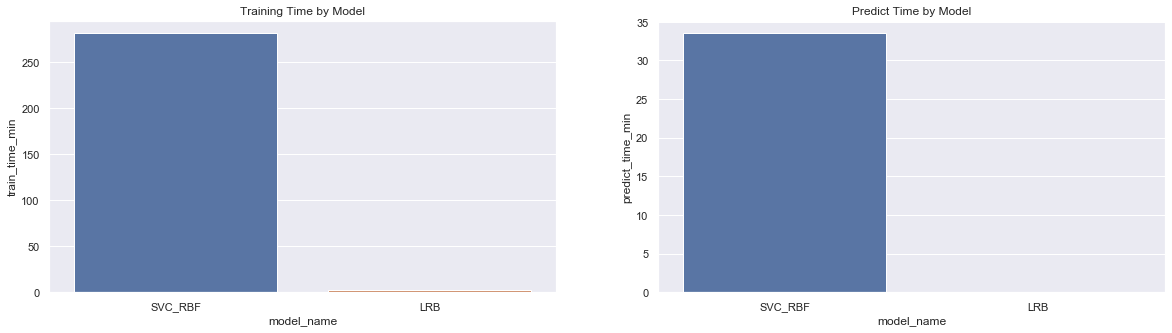

In [6]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(data=report, x="model_name", y="train_time_min", ax=a[0])
_ = a[0].set_title("Training Time by Model")
sns.barplot(data=report, x="model_name", y="predict_time_min", ax=a[1])
_ = a[1].set_title("Predict Time by Model")


# Model Result

Looking at our custom metric, SVC performs 6% worse than Logistic Regression with balanced weight

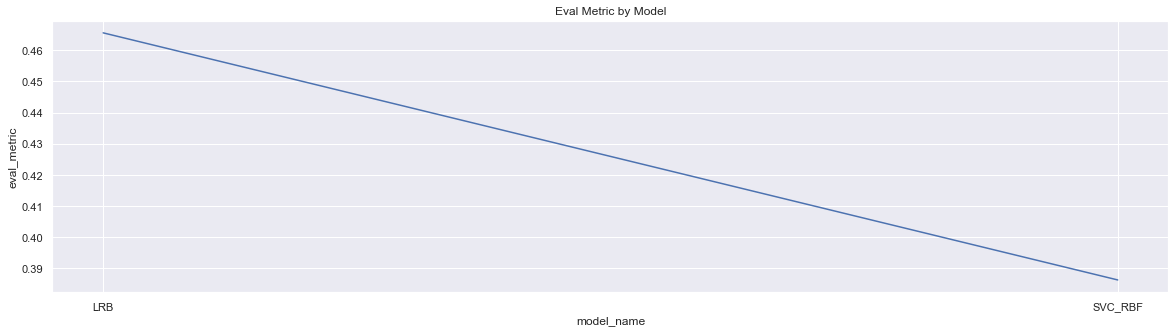

In [7]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

sns.lineplot(data=report, x="model_name", y="eval_metric")
_ = plt.title("Eval Metric by Model")

# Confusion Matrix for SVC

* 1-star reviews tend to be classified as 2-star reviews
* 2-star reviews tend to be classified as 1-star reviews
* 3-star reviews tend to be classified as 4-star reviews
* 4-star reviews tend to be classified as 5-star reviews
* 5-star reviews tend to be classified as 4-star reviews

In [8]:
pd.DataFrame(json.loads(report_svc.confusion_matrix.values[0])).rename(
                {0:"1", 1:"2", 2:"3", 3:"4", 4:"5"}, axis=1
)

,1,2,3,4,5
0,1290,188,130,54,73
1,330,153,179,100,44
2,170,136,393,339,129
3,85,62,278,969,709
4,158,46,226,1190,5015


# Classification Report

* Precision for SVC is roughly the same with minority classes being slightly higher and majority classess being slightly lower
* SVC recall is lower for 2-star looks to be really low compared to LR. 
    * Recall for 3-star rating is roughly the same
    * Recall for 1-star, 4-star and 5-tar seem to be slightly higher than LR

Logistic Regression Classification Report


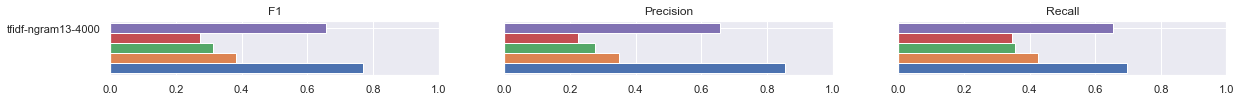


SVC Classification Report


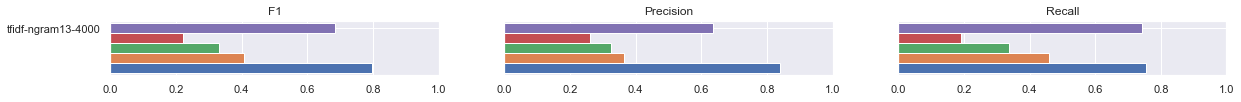

In [9]:
import util.plot_util as pu

print('Logistic Regression Classification Report')
pu.plot_score_histograms(report_lr_best, version=2)
plt.show()

print('\nSVC Classification Report')
pu.plot_score_histograms(report_svc, version=2)
